In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Standard imports
import matplotlib.pyplot as plt
import numpy as np
import poligrain as plg
import xarray as xr

# Special for plotting
from matplotlib.colors import LinearSegmentedColormap

# special for transformation
# "In house" functions
from mergeplg import merge

In [3]:
# Load processed data, resolution 5 minutes
ds_gauges = xr.open_dataset("./data/openmrg_municp_gauge.nc")
ds_cmls = xr.open_dataset("./data/openmrg_cml.nc")
ds_rad = xr.open_dataset("./data/openmrg_rad.nc")
ds_gauges_smhi = xr.open_dataset("./data/openmrg_smhi_gauge.nc")

# Fix error where lat/lon was set to variable
ds_rad = ds_rad.set_coords(["longitudes", "latitudes"])

# Fix naming errors
ds_gauges = ds_gauges.rename({"station_id": "id"})
ds_gauges_smhi = ds_gauges_smhi.rename({"station_id": "id"})

ds_rad = ds_rad.rename({"longitudes": "lon", "latitudes": "lat"})

In [4]:
# Threshold lower values
radar_zero = 0.01  # here in sum mm over 5 minutes
ds_rad["rainfall_amount"] = xr.where(
    ds_rad.rainfall_amount > radar_zero, ds_rad.rainfall_amount, 0
)

# Project data

In [5]:
# UTM32N: https://epsg.io/32632
ref_str = "EPSG:32632"

In [6]:
ds_gauges.coords["x"], ds_gauges.coords["y"] = plg.spatial.project_point_coordinates(
    ds_gauges.lon, ds_gauges.lat, ref_str
)

ds_gauges_smhi.coords["x"], ds_gauges_smhi.coords["y"] = (
    plg.spatial.project_point_coordinates(
        ds_gauges_smhi.lon, ds_gauges_smhi.lat, ref_str
    )
)

In [7]:
# For CML
(
    ds_cmls.coords["site_0_x"],
    ds_cmls.coords["site_0_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_0_lon, ds_cmls.site_0_lat, ref_str
)
(
    ds_cmls.coords["site_1_x"],
    ds_cmls.coords["site_1_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_1_lon, ds_cmls.site_1_lat, ref_str
)

# Midpoint
ds_cmls.coords["x"] = (ds_cmls.site_0_x + ds_cmls.site_1_x) / 2
ds_cmls.coords["y"] = (ds_cmls.site_0_y + ds_cmls.site_1_y) / 2

In [8]:
# Projected radar coords
ds_rad.coords["xs"], ds_rad.coords["ys"] = plg.spatial.project_point_coordinates(
    ds_rad.lon, ds_rad.lat, ref_str
)

In [9]:
time = 8
from sklearn.neighbors import NearestNeighbors

intersect_weights = plg.spatial.calc_sparse_intersect_weights_for_several_cmls(
        x1_line=ds_cmls.site_0_lon.data,
        y1_line=ds_cmls.site_0_lat.data,
        x2_line=ds_cmls.site_1_lon.data,
        y2_line=ds_cmls.site_1_lat.data,
        cml_id=ds_cmls.cml_id.data,
        x_grid=ds_rad.lon.data,
        y_grid=ds_rad.lat.data,
        grid_point_location='center',
    )

ds_cmls['rad'] = plg.spatial.get_grid_time_series_at_intersections(
        grid_data=ds_rad.rainfall_amount,
        intersect_weights=intersect_weights,
    )

ds_cmls['difference'] = ds_cmls['rad'] - ds_cmls.R

In [10]:
from sklearn.cluster import KMeans

In [28]:
cml_rad = ds_cmls.rad.isel(time = [8]).data.ravel()
cml_obs = ds_cmls.R.isel(time = [8]).data.ravel()
cml_diff = ds_cmls.difference.isel(time = [8]).data.ravel()

X = np.hstack([cml_rad.reshape(-1, 1), cml_diff.reshape(-1, 1)])

# create kmeans object
kmeans = KMeans(n_clusters=4)

# fit kmeans object to data
kmeans.fit(X)

# print location of clusters learned by kmeans object
pred = kmeans.predict(X)

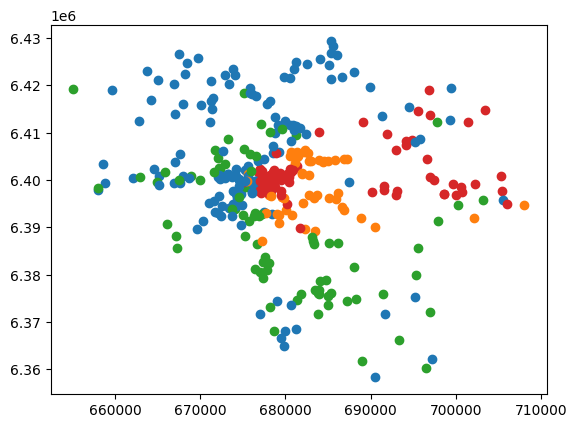

In [29]:
for i, cml_id in enumerate(ds_cmls.cml_id.data):
    x = ds_cmls.sel(cml_id = cml_id).x.data
    y = ds_cmls.sel(cml_id = cml_id).y.data
    
    for j in range(np.unique(pred).size):
        if pred[i] == j:
            plt.plot(x, y, color='C' + str(j), marker='o')

    

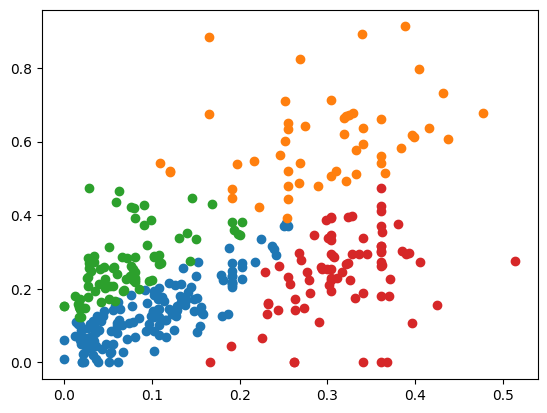

In [30]:
for j in range(np.unique(pred).size):
    data_x = cml_rad[pred == j]
    data_y = cml_obs[pred == j]
    plt.scatter(data_x, data_y, color='C' + str(j), marker='o')

In [ ]:
# Estimate copula (variogram and KED) for different clusters. 
# Interpolate baed on this 
# Then use copula uncertainty to esimtate rianfall amunts? 

In [ ]:
# Looks ok, I can here rank transform directly to the cml KDE?

In [ ]:
plt.hist(

In [36]:
# For all observations, calculate expected value based on inverse weight neighbours
cml_obs = da_cml.data.reshape(-1, 1)
cml_rad = rad_cml.data.reshape(-1, 1)

diff = cml_obs-cml_rad
y = ((da_cml.site_0_y + da_cml.site_1_y).data/2).reshape(-1, 1)
x = ((da_cml.site_0_x + da_cml.site_1_x).data/2).reshape(-1, 1)

# 


In [37]:
labels

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1

# Adjust rainfall fields

In [18]:
# Do adjustment using additive IDW
additiveIDW = merge.MergeAdditiveIDW()

adjusted_rainfall = []
for time in ds_cmls.time.data:
    # Update geometry of cmls and gauges
    additiveIDW.update(ds_rad, da_cml=ds_cmls, da_gauge=ds_gauges)

    # Perform adjustment for one timestep
    adjusted_rainfall.append(
        additiveIDW.adjust(
            ds_rad.sel(time=[time]).rainfall_amount,
            da_cml=ds_cmls.sel(time=[time]).R,
            da_gauge=ds_gauges.sel(time=[time]).rainfall_amount,
        )
    )
ds_rad["rainfall_additiveIDW"] = xr.concat(adjusted_rainfall, dim="time")

In [19]:
# Do adjustment using additive Block-Kriging
additiveBlockKriging = merge.MergeAdditiveBlockKriging()

adjusted_rainfall = []
for time in ds_cmls.time.data:
    # Update geometry of cmls and gauges
    additiveBlockKriging.update(ds_rad, da_cml=ds_cmls, da_gauge=ds_gauges)

    # Perform adjustment for one timestep
    adjusted_rainfall.append(
        additiveBlockKriging.adjust(
            ds_rad.sel(time=[time]).rainfall_amount,
            da_cml=ds_cmls.sel(time=[time]).R,
            da_gauge=ds_gauges.sel(time=[time]).rainfall_amount,
        )
    )
ds_rad["rainfall_additiveBK"] = xr.concat(adjusted_rainfall, dim="time")

In [20]:
# Do adjustment using KED
KEDBlockKriging = merge.MergeBlockKrigingExternalDrift()

# Do adjustment
adjusted_rainfall = []
for time in ds_cmls.time.data:
    # Update geometry of cmls and gauges
    KEDBlockKriging.update(ds_rad, da_cml=ds_cmls, da_gauge=ds_gauges)

    # Perform adjustment for one timestep
    adjusted_rainfall.append(
        KEDBlockKriging.adjust(
            ds_rad.sel(time=[time]).rainfall_amount,
            da_cml=ds_cmls.sel(time=[time]).R,
            da_gauge=ds_gauges.sel(time=[time]).rainfall_amount,
        )
    )
ds_rad["rainfall_KED"] = xr.concat(adjusted_rainfall, dim="time")

In [21]:
cmap_colors = [
    (0, "white"),
    (radar_zero, "white"),
    (radar_zero, (0.5, 0.75, 0.25, 1.0)),
    (1, "blue"),
]  # white -> green-yellow mix -> dark blue
cmap_rain = LinearSegmentedColormap.from_list("mycmap", cmap_colors)

In [22]:
ds_cmls

<xarray.Dataset> Size: 448B
Dimensions:       (cml_id: 3, time: 1)
Coordinates: (12/17)
    sublink_id    <U9 36B 'sublink_1'
  * cml_id        (cml_id) int64 24B 10143 10171 10201
    site_0_lat    (cml_id) float64 24B 57.69 57.93 57.41
    site_0_lon    (cml_id) float64 24B 12.14 12.38 12.01
    site_1_lat    (cml_id) float64 24B 57.63 57.82 57.54
    site_1_lon    (cml_id) float64 24B 11.97 12.34 11.96
    ...            ...
    site_0_x      (cml_id) float64 24B 6.87e+05 7.003e+05 6.807e+05
    site_0_y      (cml_id) float64 24B 6.399e+06 6.426e+06 6.367e+06
    site_1_x      (cml_id) float64 24B 6.772e+05 6.985e+05 6.774e+05
    site_1_y      (cml_id) float64 24B 6.391e+06 6.413e+06 6.382e+06
    x             (cml_id) float64 24B 6.821e+05 6.994e+05 6.791e+05
    y             (cml_id) float64 24B 6.395e+06 6.419e+06 6.374e+06
Data variables:
    R             (time, cml_id) float64 24B ...
    rad           (time, cml_id) float64 24B 0.333 0.1803 0.03651
    difference    (time, cml_id) float64 24B -0.1786 0.0537 0.02663
Attributes: (12/14)
    title:                 Transformed and resampled OpenMRG-CML
    version:               1.1
    source:                Swedish Meteorological and Hydrological Institute ...
    contact:               hydro.fou@smhi.se, jafet.andersson@smhi.se, erlend...
    license:               https://creativecommons.org/licenses/by-sa/4.0
    doi:                   https://doi.org/10.5281/zenodo.6673750
    ...                    ...
    institution:           NA
    date:                  NA
    history:               NA
    naming convention:     NA
    license restrictions:  NA
    reference:             NA

/tmp/ipykernel_2070449/340165000.py:4: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax[0].pcolormesh(
/tmp/ipykernel_2070449/340165000.py:13: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax[1].pcolormesh(
/tmp/ipykernel_2070449/340165000.py:23: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax[2].pcolormesh(
/tmp/ipykernel_2070449/340165000.py:33: UserWarning: The input coordina

jo
jo
jo
jo
jo
jo
jo
jo
jo
jo
jo
jo


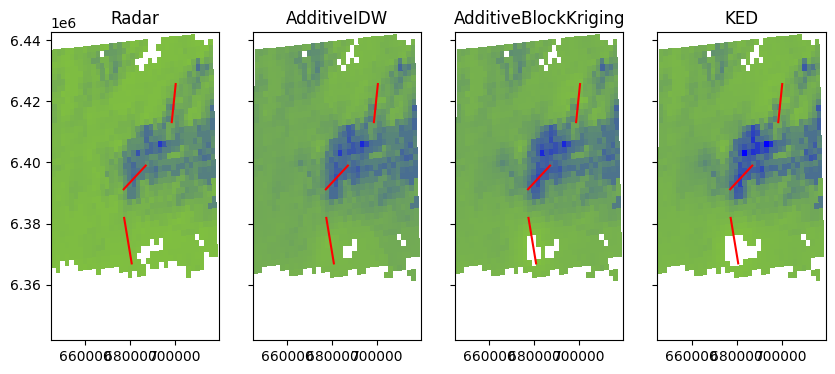

In [23]:
vmax = 1
for time in ds_cmls.time:
    fig, ax = plt.subplots(1, 4, figsize=(10, 4), sharey=True)
    ax[0].pcolormesh(
        ds_rad.xs,
        ds_rad.ys,
        ds_rad.sel(time=time).rainfall_amount.data,
        vmin=0,
        vmax=vmax,
        cmap=cmap_rain,
    )

    ax[1].pcolormesh(
        ds_rad.xs,
        ds_rad.ys,
        ds_rad.sel(time=time).rainfall_additiveIDW.data,
        vmin=0,
        vmax=vmax,
        zorder=1,
        cmap=cmap_rain,
    )

    ax[2].pcolormesh(
        ds_rad.xs,
        ds_rad.ys,
        ds_rad.sel(time=time).rainfall_additiveBK.data,
        vmin=0,
        vmax=vmax,
        zorder=1,
        cmap=cmap_rain,
    )

    ax[3].pcolormesh(
        ds_rad.xs,
        ds_rad.ys,
        ds_rad.sel(time=time).rainfall_KED.data,
        vmin=0,
        vmax=vmax,
        zorder=1,
        cmap=cmap_rain,
    )

    ax[0].set_title("Radar")
    ax[1].set_title("AdditiveIDW")
    ax[2].set_title("AdditiveBlockKriging")
    ax[3].set_title("KED")

    for ax_i in range(len(ax)):
        for cml_id in ds_cmls.cml_id:
            print('jo')
            ax[ax_i].plot(
                [
                    ds_cmls.sel(cml_id=cml_id).site_0_x,
                    ds_cmls.sel(cml_id=cml_id).site_1_x,
                ],
                [
                    ds_cmls.sel(cml_id=cml_id).site_0_y,
                    ds_cmls.sel(cml_id=cml_id).site_1_y,
                ],
                "red",
                zorder=1,
            )

#    for ax_i in range(len(ax)):
#        for station_id in ds_gauges.id:
#            ax[ax_i].scatter(
#                station_id.x,
#                station_id.y,
#                c=ds_gauges.sel(id=station_id, time=time).rainfall_amount,
#                cmap=cmap_rain,
#                edgecolors="C3",
#                vmin=0,
#                vmax=vmax,
#                s=75,
#                zorder=2,
#            )
    plt.show()

# Compare to city rain gauges

In [14]:
get_grid_at_points = plg.spatial.GridAtPoints(
    da_gridded_data=ds_rad,
    da_point_data=ds_gauges,
    nnear=1,
    stat="best",
)

radar_at_points = get_grid_at_points(
    da_gridded_data=ds_rad.rainfall_amount,
    da_point_data=ds_gauges.rainfall_amount,  # Why do we require rainfal amount?
)

IDW_at_points = get_grid_at_points(
    da_gridded_data=ds_rad.rainfall_additiveIDW,
    da_point_data=ds_gauges.rainfall_amount,  # Why do we require rainfal amount?
)

BK_at_points = get_grid_at_points(
    da_gridded_data=ds_rad.rainfall_additiveBK,
    da_point_data=ds_gauges.rainfall_amount,  # Why do we require rainfal amount?
)

KED_at_points = get_grid_at_points(
    da_gridded_data=ds_rad.rainfall_KED,
    da_point_data=ds_gauges.rainfall_amount,  # Why do we require rainfal amount?
)

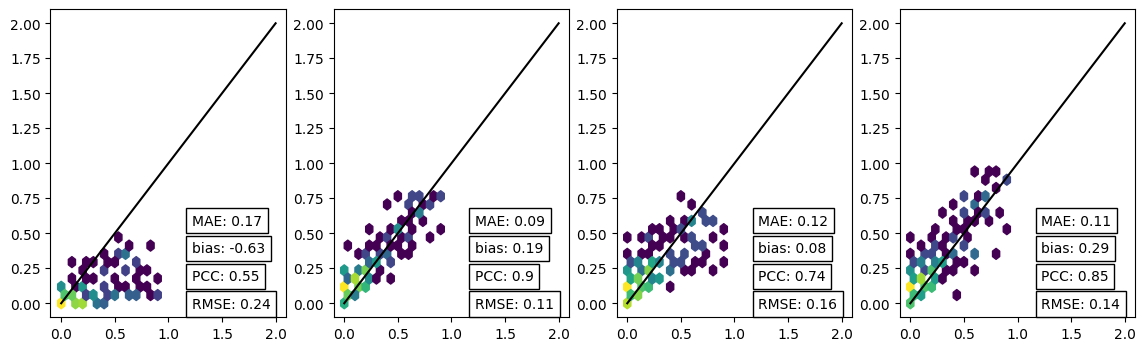

In [15]:
extent = [0, 2, 0, 2]
gridsize = 30

pred_models = [radar_at_points, IDW_at_points, BK_at_points, KED_at_points]
fig, ax = plt.subplots(1, len(pred_models), figsize=(14, 4))
ground = ds_gauges.rainfall_amount.data.ravel()
for i in range(len(pred_models)):
    tar = pred_models[i].data.ravel()

    keep = np.ones(ground.shape).astype(bool)
    keep = radar_at_points.data.ravel() > 0
    ax[i].hexbin(
        ground[keep], tar[keep], mincnt=1, extent=extent, gridsize=gridsize, bins="log"
    )
    ax[i].text(
        0.6,
        0.03,
        "RMSE: " + str(round(np.sqrt(np.mean((ground[keep] - tar[keep]) ** 2)), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.12,
        "PCC: " + str(round(np.corrcoef(ground[keep], tar[keep])[0, 1], 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.21,
        "bias: "
        + str(round(np.mean(tar[keep] - ground[keep]) / np.mean(ground[keep]), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.3,
        "MAE: " + str(round(np.mean(np.abs(tar[keep] - ground[keep])), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].plot([0, extent[1]], [0, extent[1]], "k")

# Compare to SMHI rain gauge

In [16]:
get_grid_at_points = plg.spatial.GridAtPoints(
    da_gridded_data=ds_rad,
    da_point_data=ds_gauges_smhi,
    nnear=1,
    stat="best",
)

radar_at_points = get_grid_at_points(
    da_gridded_data=ds_rad.rainfall_amount,
    da_point_data=ds_gauges_smhi.rainfall_amount,  # Why do we require rainfal amount?
)

IDW_at_points = get_grid_at_points(
    da_gridded_data=ds_rad.rainfall_additiveIDW,
    da_point_data=ds_gauges_smhi.rainfall_amount,  # Why do we require rainfal amount?
)

BK_at_points = get_grid_at_points(
    da_gridded_data=ds_rad.rainfall_additiveBK,
    da_point_data=ds_gauges_smhi.rainfall_amount,  # Why do we require rainfal amount?
)

KED_at_points = get_grid_at_points(
    da_gridded_data=ds_rad.rainfall_KED,
    da_point_data=ds_gauges_smhi.rainfall_amount,  # Why do we require rainfal amount?
)

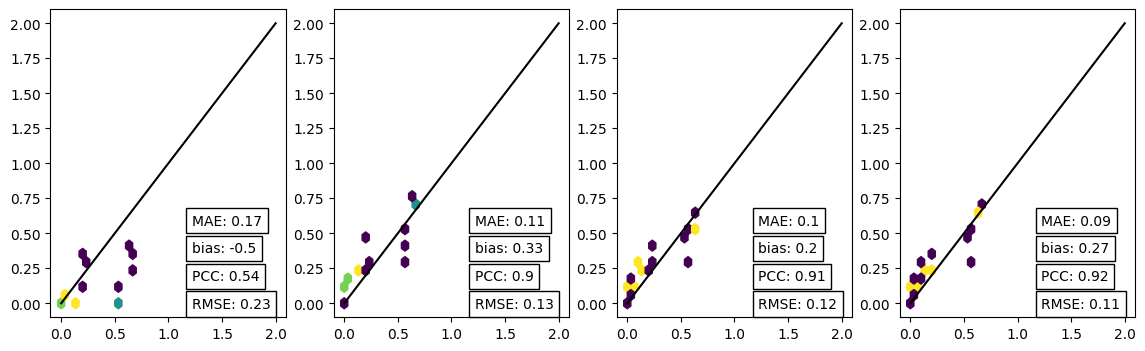

In [17]:
extent = [0, 2, 0, 2]
gridsize = 30

pred_models = [radar_at_points, IDW_at_points, BK_at_points, KED_at_points]
fig, ax = plt.subplots(1, len(pred_models), figsize=(14, 4))
ground = ds_gauges_smhi.rainfall_amount.data.ravel()
for i in range(len(pred_models)):
    tar = pred_models[i].data.ravel()

    keep = np.ones(ground.shape).astype(bool)
    keep = radar_at_points.data.ravel() > 0
    ax[i].hexbin(
        ground[keep], tar[keep], mincnt=1, extent=extent, gridsize=gridsize, bins="log"
    )
    ax[i].text(
        0.6,
        0.03,
        "RMSE: " + str(round(np.sqrt(np.mean((ground[keep] - tar[keep]) ** 2)), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.12,
        "PCC: " + str(round(np.corrcoef(ground[keep], tar[keep])[0, 1], 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.21,
        "bias: "
        + str(round(np.mean(tar[keep] - ground[keep]) / np.mean(ground[keep]), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.3,
        "MAE: " + str(round(np.mean(np.abs(tar[keep] - ground[keep])), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].plot([0, extent[1]], [0, extent[1]], "k")